In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.width = 0
pd.set_option('display.max_rows', 500)

#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

#### Calculate the tip duration from district to district
#### Customer click on the Source and Destination and he gets an estimate of the duration he will take
#### Visualize the traffic based on hourly bases


In [5]:
#### INTERNET EXAMPLE
# https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf
# https://towardsdatascience.com/how-taxis-arrive-at-fares-predicting-new-york-city-yellow-cab-fares-71a8c43b7c50

location  = "E:/Big Data Diploma/Project/Project/New folder/Taxi/Green Taxi/"

In [6]:
Green_Taxi = pd.read_csv(location+'Green_Taxi4.csv')

#Green_Taxi = pd.read_csv(location+'Green_Taxi.csv')
#.drop(columns=['VendorID','Store_and_fwd_flag','RateCodeID','Passenger_count','MTA_tax','Ehail_fee','improvement_surcharge','Payment_type','PULocationID','DOLocationID','Extra','Tip_amount','Tolls_amount','Total_amount'])


In [143]:
#Green_Taxi = Green_Taxi.drop('Trip_type')
Green_Taxi = Green_Taxi.drop('Unnamed: 0',axis = 1)

In [131]:
# Remove all Nulls
#Green_Taxi= Green_Taxi.dropna()

In [3]:
Green_Taxi.shape

NameError: name 'Green_Taxi' is not defined

In [145]:
Green_Taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9018030 entries, 0 to 9018029
Data columns (total 9 columns):
lpep_pickup_datetime     object
Lpep_dropoff_datetime    object
Pickup_longitude         float64
Pickup_latitude          float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Trip_distance            float64
Fare_amount              float64
Trip_Duration            object
dtypes: float64(6), object(3)
memory usage: 619.2+ MB


In [97]:
# We've noticed from teh describe that the min trip distance is 0 which is incorrect
# So we will need to remove the incorrect outliers
Green_Taxi.Trip_distance.describe()

count    9.018030e+06
mean     2.817058e+00
std      2.942815e+00
min      0.000000e+00
25%      1.030000e+00
50%      1.860000e+00
75%      3.530000e+00
max      8.322000e+02
Name: Trip_distance, dtype: float64

In [146]:
# We've also noticed below that we have some records with coordinates 0 which is also incorrect
# So we will remove them as well
Green_Taxi.sort_values(by='Trip_distance')[:5]

,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration
7687355,2016-06-02 21:23:04,2016-06-02 21:27:29,-73.992981,40.697563,-73.985260,40.703072,0.0,4.5,0 days 00:04:25.000000000
5155093,2016-04-12 18:26:39,2016-04-12 18:26:40,0.000000,0.000000,-73.917709,40.760563,0.0,2.5,0 days 00:00:01.000000000
7701858,2016-06-02 22:47:43,2016-06-02 22:48:43,-73.867805,40.678562,-73.867798,40.678562,0.0,7.0,0 days 00:01:00.000000000
5913565,2016-04-28 00:30:01,2016-04-28 00:30:03,-73.937103,40.827061,-73.937111,40.827068,0.0,10.0,0 days 00:00:02.000000000
5491170,2016-04-19 06:28:29,2016-04-19 06:28:40,-73.930649,40.691277,-73.930687,40.691265,0.0,15.0,0 days 00:00:11.000000000


In [147]:
#Around 119K  trip record with distance equal to 0. Below are some possible explanation for such records.
#Customer changed mind and cancelled the journey just after accepting it.
#Software didn't recorded dropoff location properly due to which dropoff location is the same as the pickup location.
#Issue with GPS tracker while the journey is being finished.
#Driver cancelled the trip just after accepting it due to some reason. So the trip couldn't start
#Or some other issue with the software itself which a technical guy can explain

print("There are {} trip records with 0 km distance".format(Green_Taxi.Trip_distance[Green_Taxi.Trip_distance == 0 ].count()))

There are 118850 trip records with 0 km distance


In [167]:
Green_Taxi = Green_Taxi[Green_Taxi.Trip_distance != 0]
Green_Taxi = Green_Taxi[Green_Taxi.Pickup_longitude != 0]
Green_Taxi = Green_Taxi[Green_Taxi.Dropoff_longitude != 0]
Green_Taxi = Green_Taxi[Green_Taxi.Trip_Duration != '0 days 00:00:00.000000000']

In [149]:
# We've also noticed Fare amounts with negative which is incorrect
Green_Taxi.sort_values(by='Fare_amount')[:10]

,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration
4522612,2016-03-31 20:29:17,2016-03-31 20:33:17,-73.824348,40.686653,-73.822273,40.687187,0.43,-450.0,0 days 00:04:00.000000000
2675985,2016-02-25 17:44:57,2016-02-25 17:45:30,-73.749565,40.703693,-73.750771,40.706371,0.11,-400.0,0 days 00:00:33.000000000
4068970,2016-03-22 16:20:18,2016-03-22 16:25:06,-73.928116,40.658321,-73.926292,40.658123,0.15,-300.0,0 days 00:04:48.000000000
3719082,2016-03-15 19:56:18,2016-03-15 19:58:42,-73.614548,40.741531,-73.614067,40.743111,0.11,-290.0,0 days 00:02:24.000000000
711706,2016-01-16 00:10:42,2016-01-16 00:12:18,-74.019775,40.624767,-74.020432,40.623959,0.06,-250.0,0 days 00:01:36.000000000
1936946,2016-02-11 07:13:37,2016-02-11 07:15:57,-73.926781,40.861401,-73.925629,40.861423,0.10,-250.0,0 days 00:02:20.000000000
198743,2016-01-04 23:47:49,2016-01-04 23:50:50,-73.968109,40.679935,-73.968765,40.678257,0.12,-240.0,0 days 00:03:01.000000000
1585785,2016-02-06 03:23:06,2016-02-06 03:26:34,-73.960960,40.694103,-73.960960,40.700935,0.27,-220.0,0 days 00:03:28.000000000
3262691,2016-03-06 15:42:00,2016-03-06 15:43:09,-73.728203,40.707722,-73.728012,40.707458,0.03,-200.0,0 days 00:01:09.000000000
4688488,2016-04-03 15:08:52,2016-04-03 15:17:55,-73.807823,40.700661,-73.807091,40.699081,0.07,-200.0,0 days 00:09:03.000000000


In [150]:
# We've also noticed Fare amounts with negative which is incorrect

print("There are {} trip records with 0 km distance".format(Green_Taxi.Fare_amount[Green_Taxi.Fare_amount < 0 ].count()))

There are 13706 trip records with 0 km distance


In [151]:
Green_Taxi = Green_Taxi[Green_Taxi.Fare_amount > 0]


In [221]:
# We've observed that the Trip Distance column has incorrect values
# Ex. How a trip duration would take 07:13:00 and customer paid 1659.00 and its only 1.35 Milles
# We will overcome that by manually calculating the trip duration
Green_Taxi.sort_values(by='Trip_distance', ascending = False)#[:200]

,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration,distance,month,week,day,hour
4608834,2016-04-02 09:04:43,2016-04-02 09:14:20,-73.941429,40.680016,-73.965866,40.695908,832.20,5.50,577.0,2.714416,4,13,2,9
1135301,2016-01-26 04:26:24,2016-01-26 15:03:38,-73.948059,40.650921,-73.952187,40.644955,360.50,989.00,38234.0,0.749248,1,4,26,4
3853337,2016-03-18 15:33:40,2016-03-18 15:41:32,-73.917946,40.815933,-73.907784,40.823963,301.00,7.00,472.0,1.236339,3,11,18,15
251634,2016-01-06 09:35:40,2016-01-06 22:43:43,-73.911613,40.824974,-72.653763,41.683697,280.16,936.00,47283.0,142.032623,1,1,6,9
7636892,2016-06-01 13:07:33,2016-06-01 15:18:47,-73.806061,40.701851,-73.740730,40.714645,268.19,3347.50,7874.0,5.687542,6,22,1,13
1274974,2016-01-29 05:44:22,2016-01-29 20:21:21,-73.868454,40.657513,-73.786041,40.709881,267.47,45.00,52619.0,9.066371,1,4,29,5
8458137,2016-06-18 06:35:52,2016-06-18 15:42:33,-73.888779,40.632839,-73.913139,40.654877,239.35,728.00,32801.0,3.198318,6,24,18,6
1580455,2016-02-04 06:53:14,2016-02-04 23:30:22,-73.891762,40.642471,-73.950241,40.654064,235.50,933.50,59828.0,5.099303,2,5,4,6
522448,2016-01-11 21:17:20,2016-01-12 03:40:46,-73.947876,40.634575,-77.526421,40.048222,233.80,636.50,23006.0,310.196946,1,2,11,21
699861,2016-01-15 20:38:15,2016-01-15 23:42:53,-73.930588,40.836643,-73.916855,40.825199,170.85,453.00,11078.0,1.718811,1,2,15,20


In [222]:
Green_Taxi[Green_Taxi['Trip_distance'] == 0.01]

#Green_Taxi.sort_values(by='Trip_distance', ascending = False)#[:200]


,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration,distance,month,week,day,hour
1795,2016-01-01 00:59:31,2016-01-01 00:59:35,-73.956787,40.666019,-73.956894,40.665703,0.01,10.00,4.0,0.036341,1,53,1,0
2231,2016-01-01 00:58:13,2016-01-01 00:59:57,-73.938850,40.802498,-73.938858,40.802303,0.01,3.00,104.0,0.021642,1,53,1,0
3540,2016-01-01 00:17:13,2016-01-01 00:17:40,-73.954063,40.719181,-73.954376,40.718922,0.01,2.50,27.0,0.039076,1,53,1,0
4296,2016-01-01 00:28:49,2016-01-01 00:29:21,-73.926773,40.691196,-73.926643,40.691204,0.01,2.50,32.0,0.010968,1,53,1,0
4736,2016-01-01 00:35:36,2016-01-01 00:35:54,-73.915344,40.828911,-73.915199,40.828896,0.01,2.50,18.0,0.012314,1,53,1,0
4997,2016-01-01 00:38:19,2016-01-01 00:38:29,-73.910385,40.854568,-73.909950,40.853439,0.01,2.50,10.0,0.130775,1,53,1,0
6583,2016-01-01 01:11:05,2016-01-01 01:11:10,-73.962044,40.709846,-73.962250,40.709904,0.01,52.00,5.0,0.018492,1,53,1,1
8134,2016-01-01 01:32:32,2016-01-01 01:32:36,-73.954506,40.731312,-73.954391,40.730995,0.01,52.00,4.0,0.036503,1,53,1,1
8930,2016-01-01 01:41:16,2016-01-01 01:41:28,-73.939835,40.708015,-73.939827,40.708069,0.01,52.00,12.0,0.005973,1,53,1,1
9185,2016-01-01 01:43:15,2016-01-01 01:44:49,-73.951210,40.709446,-73.951416,40.709511,0.01,3.00,94.0,0.018801,1,53,1,1


In [226]:
#ax = df.plot.bar(y=Green_Taxi['hour'], rot=0)


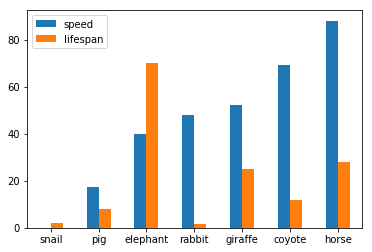

In [224]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
          'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                   'lifespan': lifespan}, index=index)
ax = df.plot.bar(rot=0)

In [159]:
from haversine import haversine

def calc_distance(df):
    pickup = (df['Pickup_latitude'], df['Pickup_longitude'])
    drop = (df['Dropoff_latitude'], df['Dropoff_longitude'])
    return haversine(pickup, drop)


In [160]:
#Calculate distance and assign new column to the dataframe.
Green_Taxi['distance'] = Green_Taxi.apply(lambda x: calc_distance(x), axis = 1)


In [217]:
#7874/60/24
Green_Taxi.sort_values(by='Trip_distance', ascending = True)[:100]

,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration,distance,month,week,day,hour
7681268,2016-06-02 15:36:15,2016-06-02 15:36:17,-73.936745,40.805351,-73.936829,40.805229,0.01,23.0,2.0,0.015302,6,22,2,15
2184707,2016-02-15 05:26:46,2016-02-15 05:26:50,-73.958023,40.815483,-73.958183,40.815273,0.01,2.5,4.0,0.026946,2,7,15,5
7220561,2016-05-23 16:37:03,2016-05-23 16:37:15,-73.938560,40.816498,-73.938751,40.816566,0.01,2.5,12.0,0.017774,5,21,23,16
3025895,2016-03-02 16:06:50,2016-03-02 16:07:01,-73.904503,40.844860,-73.904709,40.844864,0.01,10.0,11.0,0.017333,3,9,2,16
1814324,2016-02-08 10:34:30,2016-02-08 10:42:24,-73.917854,40.770035,-73.891487,40.763180,0.01,6.0,474.0,2.347736,2,6,8,10
2408802,2016-02-19 21:59:24,2016-02-19 22:00:18,-73.951790,40.824669,-73.953384,40.822475,0.01,2.5,54.0,0.278370,2,7,19,21
5580409,2016-04-21 07:00:18,2016-04-21 07:00:23,-73.799232,40.706810,-73.799706,40.706509,0.01,9.8,5.0,0.052084,4,16,21,7
821424,2016-01-17 22:23:00,2016-01-17 22:58:18,-73.937401,40.758018,-73.936722,40.764729,0.01,2.5,2118.0,0.748313,1,2,17,22
3413958,2016-03-10 00:51:23,2016-03-10 00:51:26,-73.863510,40.748531,-73.865433,40.749607,0.01,2.5,3.0,0.201342,3,10,10,0
3413964,2016-03-10 00:51:44,2016-03-10 00:52:51,-73.949036,40.680374,-73.951294,40.680496,0.01,2.5,67.0,0.190916,3,10,10,0


In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(Green_Taxi.Trip_distance)
plt.show()


In [197]:
#Green_Taxi.info()
#Green_Taxi['Trip_Duration'] = (Green_Taxi['Lpep_dropoff_datetime'] - Green_Taxi['lpep_pickup_datetime'])#.total_seconds()#.astype(float)
#Green_Taxi['Trip_Duration'] = Green_Taxi['Trip_Duration']/np.timedelta64(1,'s')


In [11]:
Green_Taxi.iloc[:, 0:2][:2]

,lpep_pickup_datetime,Lpep_dropoff_datetime
0,2016-01-01 00:29:24,2016-01-01 00:39:36
1,2016-01-01 00:19:39,2016-01-01 00:39:18


In [196]:
# Good String Character to Date Conversion example

#from datetime import datetime
#datetime_str = '2016-06-22 23:07:36'
#datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
#print(type(datetime_object))
#print(datetime_object)  # printed in default format

# VIP: The step below is very important to change from String to Datetime
# Note when converting String to Datetime it is very important to specify the exact format as 
# it makes is much faster to process the request. Also, anyother option makes the process hang

# The line below just for testing
# %timeit pd.to_datetime(Green_Taxi.lpep_pickup_datetime, format='%m/%d/%Y %I:%M:%S %p')

# The command iloc to specify the columns that we would like to 
Green_Taxi.iloc[:, 0:2] = Green_Taxi.iloc[:, 0:2].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [202]:
Green_Taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8853377 entries, 0 to 9018029
Data columns (total 14 columns):
lpep_pickup_datetime     datetime64[ns]
Lpep_dropoff_datetime    datetime64[ns]
Pickup_longitude         float64
Pickup_latitude          float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Trip_distance            float64
Fare_amount              float64
Trip_Duration            float64
distance                 float64
month                    int64
week                     int64
day                      int64
hour                     int64
dtypes: datetime64[ns](2), float64(8), int64(4)
memory usage: 1013.2 MB


In [201]:
#
Green_Taxi.to_csv(r'E:/Big Data Diploma/Project/Project/New folder/Taxi/Green Taxi/Green_Taxi5.csv')

In [199]:
Green_Taxi['month'] = Green_Taxi.lpep_pickup_datetime.apply(lambda x: x.month)
Green_Taxi['week']  = Green_Taxi.lpep_pickup_datetime.apply(lambda x: x.week)
Green_Taxi['day']   = Green_Taxi.lpep_pickup_datetime.apply(lambda x: x.day)
Green_Taxi['hour']  = Green_Taxi.lpep_pickup_datetime.apply(lambda x: x.hour)


In [8]:
#Green_Taxi[['lpep_pickup_datetime','Lpep_dropoff_datetime','Pickup_longitude','Pickup_latitude','Dropoff_longitude',
#'Dropoff_latitude','Trip_distance','Fare_amount']].to_csv(r'E:/Big Data Diploma/Project/Project/New folder/Taxi/Green Taxi/Green_Taxi.csv')
#Green_Taxi.to_csv(r'E:/Big Data Diploma/Project/Project/New folder/Taxi/Green Taxi/Green_Taxi2.csv')

In [200]:
Green_Taxi[:2]

,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration,distance,month,week,day,hour
0,2016-01-01 00:29:24,2016-01-01 00:39:36,-73.928642,40.680611,-73.924278,40.698044,1.46,8.0,612.0,1.973094,1,53,1,0
1,2016-01-01 00:19:39,2016-01-01 00:39:18,-73.952675,40.723175,-73.923920,40.761379,3.56,15.5,1179.0,4.890321,1,53,1,0


In [42]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map


In [50]:
#base_map  = generateBaseMap()

In [43]:
from folium.plugins import HeatMap
df_copy = df[df.month>4].copy()
df_copy['count'] = 1
data=df_copy[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()


In [44]:
base_map = generateBaseMap()
HeatMap(data, radius=8, max_zoom=13).add_to(base_map)

In [56]:
base_map = base_map.add_child(folium.ClickForMarker(popup='Potential Location'))

In [48]:
base_map.save('E:/Big Data Diploma/Project/Project/HeatMap.html')


In [90]:
df_hour_list = []
for hour in df_copy.hour.sort_values().unique():
    df_hour_list.append(df_copy.loc[df_copy.hour == hour, ['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist())


In [91]:
from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)


In [92]:
base_map.save('E:/Big Data Diploma/Project/Project/HeatMap2.html')


In [14]:
Green_Taxi[:2]

,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration,month,week,day,hour
0,2016-01-01 00:29:24,2016-01-01 00:39:36,-73.928642,40.680611,-73.924278,40.698044,1.46,8.0,612.0,1,53,1,0
1,2016-01-01 00:19:39,2016-01-01 00:39:18,-73.952675,40.723175,-73.923920,40.761379,3.56,15.5,1179.0,1,53,1,0


In [ ]:
############  Test Machine Learning

In [15]:
Green_Taxi = Green_Taxi.drop(columns=['lpep_pickup_datetime','Lpep_dropoff_datetime'])
Green_Taxi[:2]

,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration,month,week,day,hour
0,-73.928642,40.680611,-73.924278,40.698044,1.46,8.0,612.0,1,53,1,0
1,-73.952675,40.723175,-73.923920,40.761379,3.56,15.5,1179.0,1,53,1,0


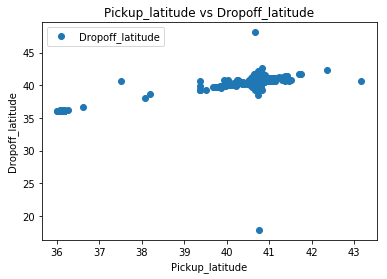

In [173]:
Green_Taxi.plot(x='Pickup_latitude', y='Dropoff_latitude', style='o')  
plt.title('Pickup_latitude vs Dropoff_latitude')  
plt.xlabel('Pickup_latitude')  
plt.ylabel('Dropoff_latitude')  
plt.show()


In [175]:
Green_Taxi.shape

(8853377, 10)

In [203]:
# Old School Code
#feature_names = ['Pickup_longitude','Pickup_latitude','Dropoff_longitude','Dropoff_latitude','Trip_distance','Fare_amount','month','week','day','hour']
feature_names = ['Pickup_longitude','Pickup_latitude','Dropoff_longitude','Dropoff_latitude','hour']
X = Green_Taxi[feature_names]
y = Green_Taxi['Trip_Duration']
#y = Green_Taxi['Trip_Duration']

In [204]:
# New School Code, Get all columns except the last one
#X = df_train.iloc[:, :-1].values
#y = df_train.iloc[:, 1].values

X[:2]

,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,hour
0,-73.928642,40.680611,-73.924278,40.698044,0
1,-73.952675,40.723175,-73.923920,40.761379,0


In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [206]:
# Plan before I sleep, To predict the Trip_distance from the coordinates
# then predict Trip_Duration & The amount
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

regressor = LinearRegression()

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

regressor.fit(X_train, y_train)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [207]:
Green_Taxi[:2]

,lpep_pickup_datetime,Lpep_dropoff_datetime,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Trip_distance,Fare_amount,Trip_Duration,distance,month,week,day,hour
0,2016-01-01 00:29:24,2016-01-01 00:39:36,-73.928642,40.680611,-73.924278,40.698044,1.46,8.0,612.0,1.973094,1,53,1,0
1,2016-01-01 00:19:39,2016-01-01 00:39:18,-73.952675,40.723175,-73.923920,40.761379,3.56,15.5,1179.0,4.890321,1,53,1,0


In [208]:
print(regressor.intercept_)
print(regressor.coef_)


31324.307403727733
[-24058.31970019  -1543.61149645  48530.67895535 -50275.83342427
   -207.7685159 ]


In [209]:
y_pred = regressor.predict(X_test)


In [212]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df[['Actual','Predicted']] = df[['Actual','Predicted']].astype(int)

In [213]:
#df['Actual'] == df['Predicted']
df#.shape

,Actual,Predicted
6947580,633,1090
751925,1988,1238
2499234,402,1283
2160993,1251,1304
752477,290,1305
1798673,781,1289
26438,794,1218
5193257,1184,1417
1134612,818,1467
2957266,546,1536


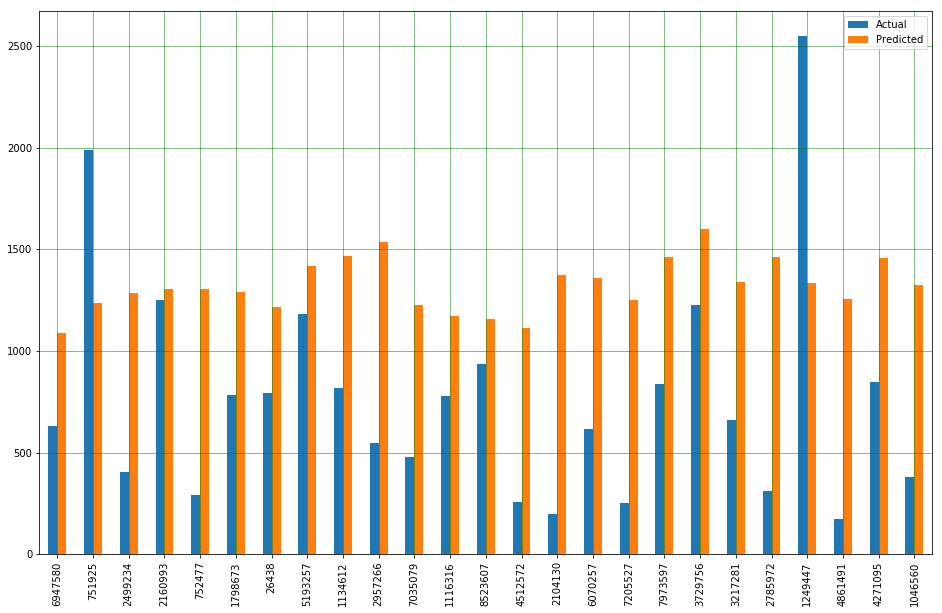

In [214]:
df_Test = df.head(25)
df_Test.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [215]:
print('Accuracy of Linear regression{:.2f}'
     .format(regressor.score(X_train, y_train)))

Accuracy of Linear regression0.00


In [216]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 1278.9693271611256
Mean Squared Error: 43896380.53870222
Root Mean Squared Error: 6625.434366039876


In [118]:
New_pred = regressor.predict(df_test)
#df_test[:2]

In [119]:
#X_test[:2]

In [120]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
pickup_longitude,135303.217204
pickup_latitude,-37913.178147
dropoff_longitude,-34337.521594
dropoff_latitude,-19270.465749
month,106.483052
week,-17.370208
day,4.014945
hour,55.468814


In [141]:
print(regressor.intercept_)


870.2303981154012


In [142]:
print(regressor.coef_)


[103.18020195  -2.42825793   7.32352152  56.72934684]


In [144]:
#plt.scatter(X_test, y_test,  color='gray')
#plt.plot(X_test, y_pred, color='red', linewidth=2)
#plt.show()
